In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

In [2]:
!pip install adversarial-robustness-toolbox


  Using cached adversarial_robustness_toolbox-1.13.1-py3-none-any.whl (1.4 MB)


In [56]:
from art.attacks.evasion import FastGradientMethod,AdversarialPatch,AutoProjectedGradientDescent,BoundaryAttack,DeepFool
import art.estimators.classification
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier

In [4]:
data_path = "D:\CDAC\PROJECT\Parkinson_MRI_data"
img_size = 128

In [7]:
data = tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        shuffle=True,
        image_size=(img_size,img_size),
        batch_size=32)

Found 21424 files belonging to 2 classes.


In [8]:
class_names = data.class_names
class_names

['non_pd', 'pd']

In [9]:
# plt.figure(figsize=(10,10))
# for image_batch, label_batch in data.take(1):
#     for i in range(9):
#         ax=plt.subplot(3,3,i+1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[label_batch[i]])
#         plt.axis("off")

In [10]:
train_DataGen = ImageDataGenerator(
                                   rescale = 1./255,
                                   rotation_range = 15,
                                   validation_split = 0.3
                                   )

In [11]:
training_data = train_DataGen.flow_from_directory(
                                                  directory = data_path,
                                                  target_size = (img_size,img_size),
                                                  batch_size = 32,
                                                  class_mode = 'binary',
                                                  subset = 'training',
                                                  color_mode="grayscale"
                                                 )

Found 14998 images belonging to 2 classes.


In [12]:
validation_data = train_DataGen.flow_from_directory(
                                                    directory = data_path,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 32,
                                                    class_mode = 'binary',
                                                    subset = 'validation',
                                                    color_mode="grayscale"
                                                   )

Found 6426 images belonging to 2 classes.


In [13]:
# Disable eager execution in TensorFlow
tf.compat.v1.disable_eager_execution()

In [16]:
# Load the Keras model
classifier = load_model("D:\CDAC\PROJECT\models\model2.h5",compile=False)

# Wrap the Keras model in an ART estimator
estimator = KerasClassifier(model=classifier, clip_values=(0, 1))

Keras model has no loss set. Classifier tries to use `k.sparse_categorical_crossentropy`.


In [17]:
import numpy as np

In [18]:
test_x1,test_y1 = validation_data.next()

In [19]:
test_y1.shape

(32,)

In [20]:
test_x1.shape

(32, 128, 128, 1)

# 1. Fast Gradient Method

In [ ]:
# class art.attacks.evasion.FastGradientMethod(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE, norm: Union[int, float, str] = inf, 
#                                              eps: Union[int, float, ndarray] = 0.3, eps_step: Union[int, float, ndarray] = 0.1, 
#                                              targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, 
#                                              minimal: bool = False, summary_writer: Union[str, bool, SummaryWriter] = False)

In [21]:
# Craft adversarial samples with FGSM
epsilon = 0.007  # Maximum perturbation
adv_crafter1 = FastGradientMethod(estimator, eps=epsilon)

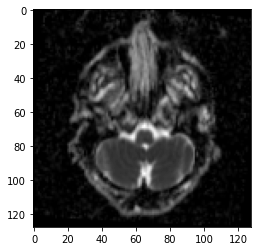

In [23]:
plt.imshow(test_x1[1,:,:],cmap = 'gray')

In [24]:
x_test_adv = adv_crafter1.generate(x=test_x1)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


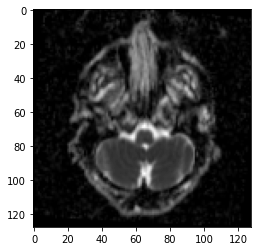

In [25]:
plt.imshow(test_x1[1,:,:],cmap = 'gray')

# 2. Adversarial Patch

In [ ]:
# class art.attacks.evasion.AdversarialPatch(classifier: CLASSIFIER_NEURALNETWORK_TYPE, rotation_max: float = 22.5, 
#                                            scale_min: float = 0.1, scale_max: float = 1.0, learning_rate: float = 5.0, 
#                                            max_iter: int = 500, batch_size: int = 16, 
#                                            patch_shape: Optional[Tuple[int, int, int]] = None, targeted: bool = True, 
#                                            verbose: bool = True)

In [26]:
test_x2,test_y2 = validation_data.next()

In [27]:
test_x2.shape

(32, 128, 128, 1)

In [28]:
test_y2.shape

(32,)

In [30]:
# Craft adversarial samples with FGSM
epsilon = 0.07  # Maximum perturbation
adv_crafter2 = AdversarialPatch(estimator)

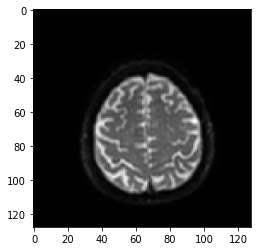

In [37]:
plt.imshow(test_x2[1],cmap = 'gray')

In [33]:
x_test_adv = adv_crafter2.generate(x=test_x2,y=test_y2)

Adversarial Patch Numpy:   0%|          | 0/500 [00:00<?, ?it/s]

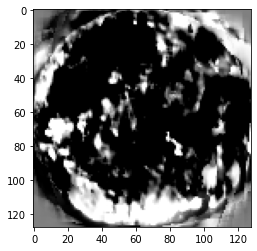

In [36]:
plt.imshow(x_test_adv[0],cmap = 'gray')

# 3. Auto Projected Gradient Descent

In [43]:
test_x3,test_y3 = validation_data.next()

In [44]:
# Craft adversarial samples with PGD
epsilon = 0.007  # Maximum perturbation
adv_crafter3 = AutoProjectedGradientDescent(estimator, eps=epsilon)

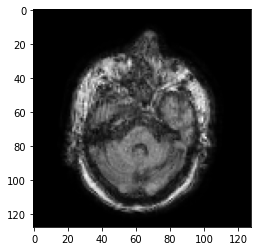

In [45]:
plt.imshow(test_x3[1,:,:],cmap = 'gray')

In [46]:
x_test_adv3 = adv_crafter3.generate(x=test_x3)

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AttributeError: 'KerasClassifier' object has no attribute '_orig_loss'

In [ ]:
plt.imshow(x_test_adv3[1,:,:],cmap = 'gray')

# 4. Boundry attack

In [ ]:
# class art.attacks.evasion.AutoProjectedGradientDescent(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE, 
#                                                        norm: Union[int, float, str] = inf, eps: float = 0.3, 
#                                                        eps_step: float = 0.1, max_iter: int = 100, targeted: bool = False, 
#                                                        nb_random_init: int = 5, batch_size: int = 32, 
#                                                        loss_type: Optional[str] = None, verbose: bool = True)

In [49]:
test_x4,test_y4 = validation_data.next()

In [50]:
# Craft adversarial samples with FGSM
epsilon = 0.007  # Maximum perturbation
adv_crafter4 = BoundaryAttack(estimator)

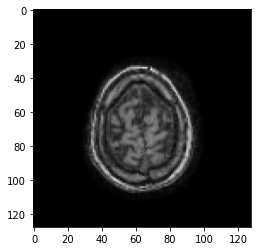

In [51]:
plt.imshow(test_x4[1,:,:],cmap = 'gray')

In [52]:
x_test_adv4 = adv_crafter4.generate(x=test_x4,y=test_y4)

Boundary attack:   0%|          | 0/32 [00:00<?, ?it/s]

Failed to draw a random image that is adversarial, attack failed.
Failed to draw a random image that is adversarial, attack failed.


Boundary attack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

Adversarial example found but not optimal.
Failed to draw a random image that is adversarial, attack failed.
Failed to draw a random image that is adversarial, attack failed.


Boundary attack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

Failed to draw a random image that is adversarial, attack failed.
Failed to draw a random image that is adversarial, attack failed.
Failed to draw a random image that is adversarial, attack failed.
Failed to draw a random image that is adversarial, attack failed.
Failed to draw a random image that is adversarial, attack failed.


Boundary attack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

Failed to draw a random image that is adversarial, attack failed.
Failed to draw a random image that is adversarial, attack failed.


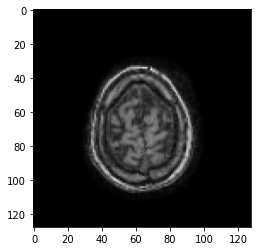

In [53]:
plt.imshow(x_test_adv4[1,:,:],cmap = 'gray')

# 5. Deep Fool

In [ ]:
# class art.attacks.evasion.DeepFool(classifier: CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE, max_iter: int = 100, 
#                                    epsilon: float = 1e-06, nb_grads: int = 10, batch_size: int = 1, verbose: bool = True)

In [54]:
train_x5,test_y5=training_data.next()

In [57]:
# Craft adversarial samples with FGSM
#epsilon = 0.007  # Maximum perturbation
adv_crafter5 = DeepFool(estimator)

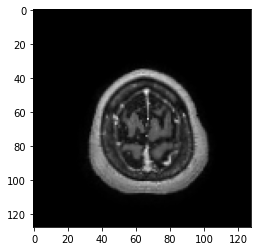

In [59]:
plt.imshow(train_x5[1,:,:],cmap = 'gray')

In [60]:
x_test_adv5 = adv_crafter5.generate(x=train_x5)

DeepFool:   0%|          | 0/32 [00:00<?, ?it/s]

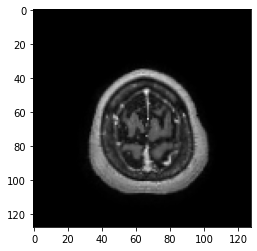

In [61]:
plt.imshow(x_test_adv5[1,:,:],cmap = 'gray')

In [63]:
# Evaluate the classifier on the adversarial examples
preds = np.argmax(estimator.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(test_y5.astype(dtype = 'int64'))) 
print("\nTest accuracy on adversarial sample: %.2f%%" % (acc))


Test accuracy on adversarial sample: 1.00%
